In [251]:
import numpy as np
import sys
from abc import ABC, abstractmethod
from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, r2_score


def make_classification(r0=1, r1=3, k=1000):
    """
    Creaci ́on de los datos
    """
    X1 = [np.array([r0*np.cos(t), r0*np.sin(t)]) for t in range(0,k)]
    X2 = [np.array([r1*np.cos(t), r1*np.sin(t)]) for t in range(0,k)]
    X = np.concatenate((X1,  X2))
    n, d = X.shape
    Y = np.zeros(2*k)
    Y[k:] += 1
    noise = np.array([np.random.normal(0, 1, 2) for i in range(n)])
    X += 0.5*noise
    return X, Y

In [252]:
class Node(ABC):
    '''Clase base abstracta para nodos en una red neuronal.'''

    def __init__(self, has_weights: bool = False):
        self.output: np.ndarray | float = None # type: ignore
        self.grad: np.ndarray | Tuple[np.ndarray, ...] | None = None
        self.has_weights = has_weights

    def __call__(self, *x) -> np.ndarray:
        return self.forward(*x)

    @abstractmethod
    def forward(self, x) -> np.ndarray:
        '''Ejecuta la operación de propagación hacia adelante para este nodo..'''

    @abstractmethod
    def backward(self, incoming_grad) -> np.ndarray | None:
        '''Calcula el gradiente durante la retropropagación para este nodo.'''

class Linear(Node):

    def __init__(self, input_size: int, output_size: int):
        super().__init__(has_weights = True)
        self.w = np.random.rand(input_size, output_size) # filas neuronas, columnas pesos
        self.b = np.random.rand(output_size) # [:, np.newaxis] tranforma en un vector columna
        self.previuslayer: Optional[np.ndarray] = None # salida de la capa anterior
        self.acumWG = np.zeros_like(self.w)
        self.acumBG = np.zeros_like(self.b) 
        self.epsilon = 1e-8

    def forward(self, x) -> np.ndarray:
        self.previuslayer = x
        self.output = np.dot(self.previuslayer, self.w) + self.b
        return self.output
    
    def backward(self, incoming_grad) -> None:
        self.grad = np.dot(incoming_grad, self.w.T)

        self.grad_w = np.dot(self.previuslayer.T, incoming_grad)
        self.grad_b = np.sum(incoming_grad, axis=0)
        return self.grad

    def updateParam(self, lr):
        self.acumWG += self.grad_w**2
        self.acumBG += self.grad_b**2

        adjustW = lr / (np.sqrt(self.acumWG) + self.epsilon)
        adjustB = lr / (np.sqrt(self.acumBG) + self.epsilon)

        self.w -= adjustW * self.grad_w
        self.b -= adjustB * self.grad_b
        




class ReLU(Node):
    
    def __init__(self):
        super().__init__()
        self.a: Optional[np.ndarray] = None # preactivacion

    def forward(self, x):
        self.a = x
        self.output = np.maximum(0, self.a) # funcion de maximo aplicado a cada entrada
        return self.output
    
    def backward(self, incoming_grad):
        self.grad = incoming_grad * (self.a > 0) # (self.a > 0) es matriz de booleanos (una mascara)
        return self.grad


class Tanh(Node):

    def __init__(self):
        super().__init__()
        self.a: Optional[np.ndarray] = None

    def forward(self, x):
        self.a = np.clip(x, -18.5, 18.5) # evitando errores numericos pues np.tanh(19) = 1 !
        self.output = np.tanh(self.a)
        return self.output 

    def backward(self, incoming_grad):
        self.grad = incoming_grad * (1 - self.output ** 2)
        return self.grad


class Softmax(Node):

    def __init__(self):
        super().__init__()
        self.a: Optional[np.ndarray] = None   

    def forward(self, x) -> np.ndarray:
        self.a = np.clip(x, -709, 709) # evitando errores numericos pues np.exp(-746) = 0.0 y np.exp(710) = inf
        exp_a = np.exp(self.a)
        sum_column = np.sum(exp_a, axis=0) # vector con las sumas aculadas de cada columna
        self.output = exp_a / sum_column # division de cada elemento por su suma de columna correspondiente
        return self.output
    
    def backward(self, incoming_grad) -> np.ndarray:
        self.grad = incoming_grad * (self.output * (1 - self.output))

        for i in range(self.output.shape[0]):
            mask = np.ones(self.output.shape[0], dtype=bool)
            mask[i] = False
            _sum = np.sum(incoming_grad[mask] * (- self.output[mask]), axis=0)
            self.grad[i] += _sum * self.output[i]
            
        return self.grad

class CrossEntropy(Node):
    
    def __init__(self,):
        super().__init__()
    
    def forward(self, y_pred, y_real) -> np.ndarray:
        epsilon = 1e-9
        entry_contribution = y_real * np.log(y_pred + epsilon)
        self.output = - np.sum(entry_contribution, axis=0)
        return self.output 

    def backward(self, y_pred, y_real) -> np.ndarray:
        return - (y_real / (y_pred + 1e-9))


class Sequential(Node):
    def __init__(self, *layers: tuple[Node, ...], error_node=None):
        super().__init__()
        self.layers: Tuple[Node, ...] = layers
        self.params: List[Node] = [] # Nodos/capas con pesos
        for layer in layers:
            if layer.has_weights:
                self.params.append(layer)
        
        self.error_node: Node = error_node
    
    def forward(self, x: np.ndarray):
        actual_val = x
        for layer in self.layers:
            actual_val = layer(actual_val)
        self.output = actual_val
        return self.output
    
    def backward(self, y_pred, y_real):
        grad = self.error_node.backward(y_pred, y_real)
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
        return grad 

class adagradOptimizer():
    def __init__(self, model, lr, epochs):
        self.lr = lr
        self.model = model
        self.epochs = epochs

    def optimize(self, X, Y):
        batch_size = len(X)
        for i in tqdm(range(self.epochs)):
            y_pred = self.model.forward(X)
            self.model.backward(y_pred,Y)
            for param in self.model.params:
                param.updateParam(self.lr)



In [253]:
def create_mini_batches(X, Y, batch_size):
    mini_batches = []
    indices = np.arange(X.shape[0]) # arreglo con los indices de cada dato 
    np.random.shuffle(indices) # los mezclamos

    # Dividimos en mini-batches
    for i in range(0, X.shape[0], batch_size):
        batch_indices = indices[i:i + batch_size]
        X_batch = X[batch_indices]
        Y_batch = Y[batch_indices]
        mini_batches.append((X_batch, Y_batch))

    return mini_batches

In [254]:
x, y = make_classification()
x_train, x_eval, y_train, y_eval = train_test_split(x, y, test_size=0.3)

y_one_hot = np.eye(2)[y.astype(int)]
mini_batches = create_mini_batches(x, y_one_hot, 10) 

In [255]:
network = Sequential(Linear(2, 10), ReLU(), Linear(10, 2), Softmax(), error_node=CrossEntropy())
optimizer = adagradOptimizer(model= network, lr=0.1, epochs=10)
optimizer2 = adagradOptimizer(model= network, lr=0.1, epochs=30)


In [256]:
#One batch
for mini_batch in mini_batches:
    optimizer.optimize(X=mini_batch[0], Y=mini_batch[1])
for mini_batch in mini_batches:
    optimizer2.optimize(X=mini_batch[0], Y=mini_batch[1])


100%|██████████| 30/30 [00:00<00:00, 3960.63it/s]


In [257]:
predictions = network(x_eval)        
y_pred = np.argmax(predictions, axis=1)
print(classification_report(y_pred, y_eval, target_names=['Class 0', 'Class 1'], zero_division=0))

              precision    recall  f1-score   support

     Class 0       0.97      0.93      0.95       319
     Class 1       0.93      0.97      0.95       281

    accuracy                           0.95       600
   macro avg       0.95      0.95      0.95       600
weighted avg       0.95      0.95      0.95       600



In [258]:
def create_plot_of_points(x: np.ndarray, y: np.ndarray, title: str) -> None:
    import matplotlib.pyplot as plt

    plt.scatter(x[:,0], x[:,1], s=5, c=np.where(y == 0, 'blue', 'red'))

    blue_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=5, label='Class 0')
    red_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=5, label='Class 1')

    plt.legend(handles=[blue_patch, red_patch], title='Classes', fontsize='small')

    plt.title(title)
    plt.savefig(f'{title}.png')
    print(f"file saved as: '{title}.png'")

file saved as: 'real_classification.png'


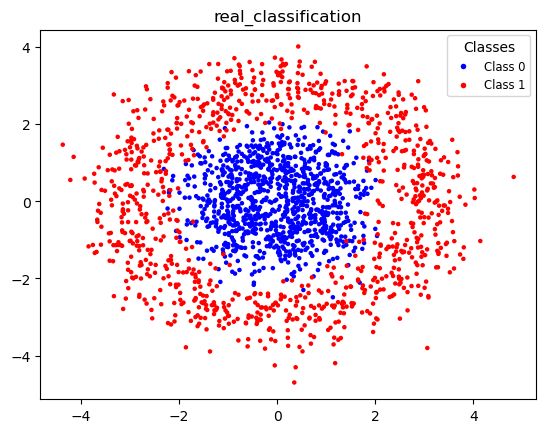

In [259]:
create_plot_of_points(x, y, 'real_classification')


file saved as: 'Trained_classification_prediction.png'


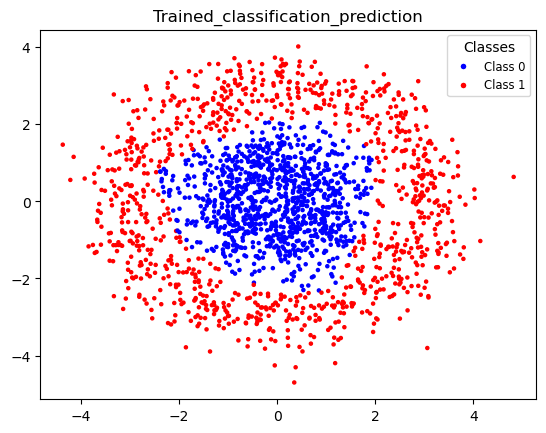

In [261]:
predictions = network(x)        
y_pred = np.argmax(predictions, axis=1)
create_plot_of_points(x, y_pred, 'Trained_classification_prediction')
